In [0]:
landing_zone_path = "/path/to/landing/zone"
staging_zone_path = "/path/to/staging/zone"

In [0]:
joined_df = spark.read.parquet(staging_zone_path)

In [0]:
joined_df.show()

+-------+------------+--------------------+--------------+--------------------+------+------------+-------+-----+-----+---+----------------+---------+----------+--------------+-------+-----------+------+------+---------------+------+-----------------+--------------+----+----------------+
|cust_id|        City|              County|Customer Since|              E Mail|Gender|  Place Name| Region|State|  Zip|age|       full_name| order_id|order_date|        status|item_id|qty_ordered| price| value|discount_amount| total|         category|payment_method|year|transaction_date|
+-------+------------+--------------------+--------------+--------------------+------+------------+-------+-----+-----+---+----------------+---------+----------+--------------+-------+-----------+------+------+---------------+------+-----------------+--------------+----+----------------+
|  91112|   Brunswick|           Brunswick|          NULL|isidro.aderholt@c...|     M|   Brunswick|Midwest|   MI|49313| 45|Aderholt, 

In [0]:
from pyspark.sql.functions import year, month, sum, col, rank
from pyspark.sql.functions import sum, col, count, year, month, avg, lit, datediff, udf
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql.functions import max as _max, datediff, lit

import matplotlib.pyplot as plt
import seaborn as sns

1.	Find revenue generated by different categories for the month of 11/2020.

In [0]:
revenue_nov_2020 = joined_df.filter((month("transaction_date") == 11) & (year("transaction_date") == 2020)) \
                            .groupBy("category") \
                            .agg(sum("total").alias("revenue")) \
                            .orderBy("category")
revenue_nov_2020.show()

+------------------+------------------+
|          category|           revenue|
+------------------+------------------+
|        Appliances| 451277.6999999996|
| Beauty & Grooming|183361.69999999975|
|             Books|1158.6499999999999|
|         Computing| 589000.0000000007|
|     Entertainment|2416405.2700000023|
|   Health & Sports|           62118.8|
|     Home & Living|56130.650000000016|
|       Kids & Baby| 39704.51999999998|
|     Men's Fashion| 243236.6399999977|
| Mobiles & Tablets| 6147953.419999958|
|            Others| 699349.4699999996|
|School & Education|4309.2300000000005|
|           Soghaat| 36532.14999999992|
|        Superstore|116809.24000000025|
|   Women's Fashion|  437664.599999998|
+------------------+------------------+



2.	Which top 5 categories have a maximum number of refunds in the year 2020?

In [0]:
refunds_2020 = joined_df.filter((year("transaction_date") == 2020) & (col("status") == "refund")) \
                        .groupBy("category") \
                        .count() \
                        .withColumnRenamed("count", "num_refunds") \
                        .orderBy(col("num_refunds").desc()) \
                        .limit(5)
refunds_2020.show()

+-----------------+-----------+
|         category|num_refunds|
+-----------------+-----------+
|    Men's Fashion|        518|
|  Women's Fashion|        216|
|    Home & Living|        177|
|Beauty & Grooming|        138|
|Mobiles & Tablets|        134|
+-----------------+-----------+



3.	Find a total number of orders by each category for each month and year in the dataset?

In [0]:
orders_by_month_year = joined_df.groupBy("category", year("transaction_date").alias("year"), month("transaction_date").alias("month")) \
                               .count() \
                               .withColumnRenamed("count", "num_orders") \
                               .orderBy("category", "year", "month")
orders_by_month_year.show()

+-----------------+----+-----+----------+
|         category|year|month|num_orders|
+-----------------+----+-----+----------+
|       Appliances|2020|   10|       512|
|       Appliances|2020|   11|       672|
|       Appliances|2020|   12|     14306|
|       Appliances|2021|    1|      1920|
|       Appliances|2021|    2|      1035|
|       Appliances|2021|    3|      2759|
|       Appliances|2021|    4|      3237|
|       Appliances|2021|    5|      1016|
|       Appliances|2021|    6|      4213|
|       Appliances|2021|    7|      1345|
|       Appliances|2021|    8|       878|
|       Appliances|2021|    9|      1141|
|Beauty & Grooming|2020|   10|       753|
|Beauty & Grooming|2020|   11|      1048|
|Beauty & Grooming|2020|   12|      4855|
|Beauty & Grooming|2021|    1|      2026|
|Beauty & Grooming|2021|    2|      1088|
|Beauty & Grooming|2021|    3|      1290|
|Beauty & Grooming|2021|    4|      1237|
|Beauty & Grooming|2021|    5|       964|
+-----------------+----+-----+----

4.	Segment customers by age: 0-20 as young, 20-35 adults, 35-55 middle-ages and >55 Old. Find the total spend (in percentage of total spend of categories) by customers by different age segments by different categories.
  E.g., Categories	Total Spend	Young	Adults	Middle-Age	Old
  E.g., In appliances category total spend is X amount of which a,b,c,d are percentages contributed from Young, Adults, Middle-Age and Old respectively. (a+b+c+d=100)


In [0]:
# Define the age segments
def age_segment(age):
    if age <= 20:
        return "Young"
    elif 20 < age <= 35:
        return "Adults"
    elif 35 < age <= 55:
        return "Middle-Age"
    else:
        return "Old"

age_udf = udf(age_segment, StringType())

# Add age segment column
joined_df = joined_df.withColumn("age_segment", age_udf(col("age")))

# Calculate total spend by age segment
spend_by_age_segment = joined_df.groupBy("category", "age_segment") \
                                .agg(sum("total").alias("total_spend")) \
                                .groupBy("category") \
                                .pivot("age_segment") \
                                .sum("total_spend")
spend_by_age_segment.show()

+------------------+--------------------+-------------------+--------------------+------------------+
|          category|              Adults|         Middle-Age|                 Old|             Young|
+------------------+--------------------+-------------------+--------------------+------------------+
|School & Education|   47174.29000000001|           31026.35|  30614.920000000002|           5924.65|
|       Kids & Baby|  221854.90000000005| 269195.65000000026|   303246.2500000001|          61917.89|
|     Entertainment|          7189929.72|  9752861.409999982|    9044465.33999999|1151180.0599999996|
|         Computing|   2443739.390000001| 3695447.7400000035|   2830799.580000002|392317.30000000005|
| Mobiles & Tablets|3.2530062600000113E7|4.721478840999974E7|4.3973306510000154E7| 6390340.739999997|
| Beauty & Grooming|    752270.799999999|  827526.8599999982|   926114.8499999981|         138837.04|
|   Health & Sports|  207678.96000000008| 400249.58000000066|   379127.9400000001|

5.	Spend by gender across different categories in terms of percentages.

In [0]:
spend_by_gender = joined_df.groupBy("category", "Gender") \
                           .agg(sum("total").alias("total_spend")) \
                           .groupBy("category") \
                           .pivot("Gender") \
                           .sum("total_spend")
spend_by_gender.show()

+------------------+--------------------+--------------------+
|          category|                   F|                   M|
+------------------+--------------------+--------------------+
|School & Education|  51004.149999999994|            63736.06|
|       Kids & Baby|   424267.5400000004|  431947.15000000043|
|     Entertainment|1.3445212409999972E7|1.3693224119999964E7|
|         Computing|   4305780.760000005|   5056523.250000002|
| Mobiles & Tablets| 6.626336183999972E7| 6.384513641999955E7|
| Beauty & Grooming|  1272931.8499999954|  1371817.6999999979|
|   Health & Sports|  416264.38000000024|   603693.7500000009|
|           Soghaat|  282647.13000000076|  293972.17000000033|
|             Books|  13034.750000000004|            19382.21|
|            Others|   7374590.840000003|   8189743.520000005|
|        Superstore|   1364017.220000001|  1522893.7000000002|
|     Men's Fashion|  2277412.6799999974|    2542737.76000002|
|        Appliances| 1.502506681999991E7|1.503577295999

6.	Find top 5 customers for each month. The results should be as follows:   E.g., Year, Month, Custid, Name, country, Gender, Total Spend, Rank

In [0]:
windowSpec = Window.partitionBy(year("transaction_date"), month("transaction_date")).orderBy(col("total").desc())

top_customers = joined_df.withColumn("rank", rank().over(windowSpec)) \
                         .filter(col("rank") <= 5) \
                         .select(year("transaction_date").alias("year"), month("transaction_date").alias("month"), "cust_id", "full_name", "Region", "Gender", "total", "rank")
top_customers.show()

+----+-----+-------+--------------------+---------+------+-------+----+
|year|month|cust_id|           full_name|   Region|Gender|  total|rank|
+----+-----+-------+--------------------+---------+------+-------+----+
|2020|   10|  61038|  Brazeal, Cornelius|    South|     M|21799.8|   1|
|2020|   10|  61038|  Brazeal, Cornelius|    South|     M|21799.8|   1|
|2020|   10|  61039|         Futral, Lou|    South|     M|21799.8|   1|
|2020|   10|  61038|  Brazeal, Cornelius|    South|     M|20309.2|   4|
|2020|   10|  60767|     Westley, Rupert|Northeast|     M|19400.0|   5|
|2020|   10|  60767|     Westley, Rupert|Northeast|     M|19400.0|   5|
|2020|   10|  60767|     Westley, Rupert|Northeast|     M|19400.0|   5|
|2020|   10|  60767|     Westley, Rupert|Northeast|     M|19400.0|   5|
|2020|   11|  56157|        Geraci, Theo|    South|     M|21799.8|   1|
|2020|   11|  64678|      Leija, Francis|Northeast|     M|21649.4|   2|
|2020|   11|  64141|  Humphreys, Johnson|    South|     M|11500.

7.	Calculate the RFM values for each customer (by customer id).
  For Recency calculation, use 31/10/2021 as last date. So, the recency for any customer should be how many weeks before he or she has made the last purchase from the date of 01/10/2021.


In [0]:
# Recency
last_date = lit("2021-10-31")
recency = joined_df.groupBy("cust_id") \
                   .agg(datediff(last_date, _max("transaction_date")).alias("recency"))

# Frequency
frequency = joined_df.groupBy("cust_id").count().withColumnRenamed("count", "frequency")

# Monetary
monetary = joined_df.groupBy("cust_id").agg(sum("total").alias("monetary"))

# Combine RFM
rfm = recency.join(frequency, "cust_id").join(monetary, "cust_id")

rfm.show()

+-------+-------+---------+------------------+
|cust_id|recency|frequency|          monetary|
+-------+-------+---------+------------------+
|  91141|    244|        1|             600.0|
|  91299|    213|        5|499.79999999999995|
|  91367|    244|        1|              41.0|
|  91446|    244|        2|             289.4|
|  91784|    213|        1|           1042.91|
|  91785|    213|        4|           7416.33|
|  91937|    213|        6|            7205.0|
|  92080|    213|        1|             129.0|
|  92182|    213|        4|             345.0|
|  92188|    213|        1|              35.0|
|  92235|    213|        2|             113.9|
|  92317|    213|        3|             134.0|
|  92644|    213|        4|           7230.36|
|  92834|    213|        1|              65.0|
|  92959|    213|        3|             316.7|
|  93319|    213|        4|            2400.0|
|  93341|    213|        2|           1362.31|
|  93407|    213|        1|              33.0|
|  93486|    

8.		Find top 10 customers based on frequency and monetary value. Sort them based on first frequency and then monetary value.

In [0]:
top_10_customers = frequency.join(monetary, "cust_id") \
                            .orderBy(col("frequency").desc(), col("monetary").desc()) \
                            .limit(10)
top_10_customers.show()

+-------+---------+------------------+
|cust_id|frequency|          monetary|
+-------+---------+------------------+
|  85775|     2524| 91441.20000000016|
|  87724|      707| 86216.88000000018|
|  96927|      608| 85166.97000000016|
|  65910|      436|53451.389999999956|
|  39707|      397|1295994.5799999973|
|  44830|      329|25101.720000000016|
|   9510|      306|          76455.71|
|  83736|      304|450104.79000000056|
|   8591|      285| 62250.07999999996|
|    800|      277| 165276.7599999999|
+-------+---------+------------------+



9.	Add three more insights as you consider essential to gain insights.
•	Clearly mention the questions under “Additional Insights” section and solve them.
#### Additional Insights

a. Average Order Value by Category

In [0]:
average_order_value = joined_df.groupBy("category") \
                               .agg(avg("total").alias("avg_order_value"))
average_order_value.show()

+------------------+------------------+
|          category|   avg_order_value|
+------------------+------------------+
|School & Education|105.26624770642204|
|     Entertainment| 1563.994728561553|
|       Kids & Baby|131.88766019716562|
|         Computing|1154.5571599457382|
| Mobiles & Tablets| 2106.713163425555|
| Beauty & Grooming|147.75962623610314|
|   Health & Sports|121.12078494240588|
|           Soghaat|  79.5556429359824|
|             Books| 39.82427518427517|
|            Others| 596.1519212501914|
|        Superstore| 192.1532827476042|
|     Men's Fashion|118.39339866873567|
|        Appliances| 909.9969661560779|
|   Women's Fashion|234.69489341427345|
|     Home & Living|129.41979985703998|
+------------------+------------------+



b. Customer Loyalty (Repeat Purchases)

In [0]:
repeat_purchases = joined_df.groupBy("cust_id").count() \
                            .filter(col("count") > 1) \
                            .orderBy(col("count").desc())
repeat_purchases.show()

+-------+-----+
|cust_id|count|
+-------+-----+
|  85775| 2524|
|  87724|  707|
|  96927|  608|
|  65910|  436|
|  39707|  397|
|  44830|  329|
|   9510|  306|
|  83736|  304|
|   8591|  285|
|    800|  277|
|  87132|  263|
|   4797|  241|
|  30465|  240|
|     56|  233|
|  83364|  231|
|     32|  230|
|  26574|  226|
|  50256|  226|
| 113694|  223|
|  75861|  219|
+-------+-----+
only showing top 20 rows



In [0]:
# Count the number of purchases per customer per category
repeat_purchases_detail = joined_df.groupBy("cust_id", "category").agg(count("order_id").alias("num_purchases"))

# Filter for customers with more than one purchase in any category
repeat_purchases_detail = repeat_purchases_detail.filter(col("num_purchases") > 1)

# Order by cust_id and num_purchases for readability
repeat_purchases_detail = repeat_purchases_detail.orderBy("cust_id", col("num_purchases").desc())

# Adjusted ordering: primary sort by num_purchases, secondary sort by cust_id
repeat_purchases_detail = repeat_purchases_detail.orderBy(col("num_purchases").desc(), "cust_id")

# Show the result
repeat_purchases_detail.show()


+-------+-----------------+-------------+
|cust_id|         category|num_purchases|
+-------+-----------------+-------------+
|  85775|  Health & Sports|         2524|
|  87724|    Men's Fashion|          408|
|  39707|Mobiles & Tablets|          397|
|  96927|    Men's Fashion|          303|
|  87724|Mobiles & Tablets|          281|
|  87132|           Others|          258|
|  44830|       Superstore|          255|
|  65910|    Home & Living|          231|
|  96927|          Soghaat|          204|
| 113694|Mobiles & Tablets|          198|
|  59331|Mobiles & Tablets|          197|
|   1423|           Others|          174|
|  26574|       Superstore|          173|
|  59587|           Others|          171|
|   5769|Mobiles & Tablets|          164|
|  85385|           Others|          152|
|  83736|Mobiles & Tablets|          151|
|  59158|  Women's Fashion|          147|
| 108638|  Women's Fashion|          146|
| 109509|       Superstore|          142|
+-------+-----------------+-------

c.  most popular categories for repeat purchases

In [0]:
# Aggregate to find most popular categories for repeat purchases
popular_repeat_categories = repeat_purchases_detail.groupBy("category").count().orderBy(col("count").desc())

# Show the result
popular_repeat_categories.show()

+------------------+-----+
|          category|count|
+------------------+-----+
| Mobiles & Tablets| 9459|
|     Men's Fashion| 7549|
|        Appliances| 5750|
|            Others| 5282|
|   Women's Fashion| 4628|
|     Entertainment| 3082|
| Beauty & Grooming| 2923|
|     Home & Living| 2502|
|        Superstore| 1719|
|         Computing| 1454|
|       Kids & Baby| 1254|
|   Health & Sports| 1062|
|           Soghaat|  972|
|School & Education|  186|
|             Books|  135|
+------------------+-----+



some other insight

Most Popular Payment Method

In [0]:
popular_payment = joined_df.groupBy("payment_method").count() \
                           .orderBy(col("count").desc())
popular_payment.show()

+-----------------+------+
|   payment_method| count|
+-----------------+------+
|              cod|102911|
|          Easypay| 69679|
|          Payaxis| 31049|
|  easypay_voucher| 29763|
|      bankalfalah| 23057|
|       Easypay_MA| 11536|
|       jazzwallet|  6669|
|      jazzvoucher|  6045|
|   customercredit|  3702|
|              apg|  1758|
|          mcblite|   208|
|   cashatdoorstep|     9|
|financesettlement|     1|
+-----------------+------+



# Dashboard

#### Revenue by Categories for 11/2020

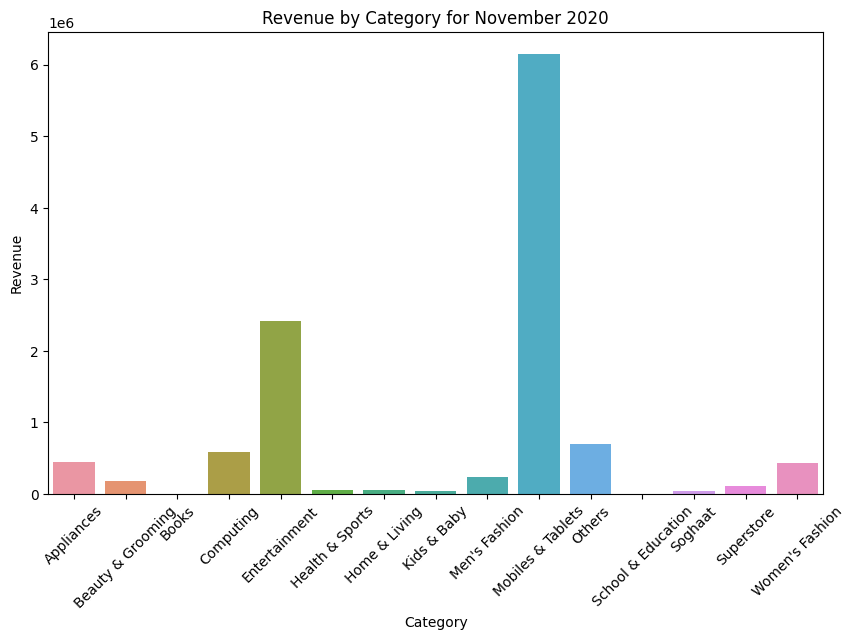

In [0]:
revenue_nov_2020_pd = revenue_nov_2020.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='revenue', data=revenue_nov_2020_pd)
plt.xticks(rotation=45)
plt.title('Revenue by Category for November 2020')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.show()

#### Top 5 Categories with Maximum Refunds in 2020

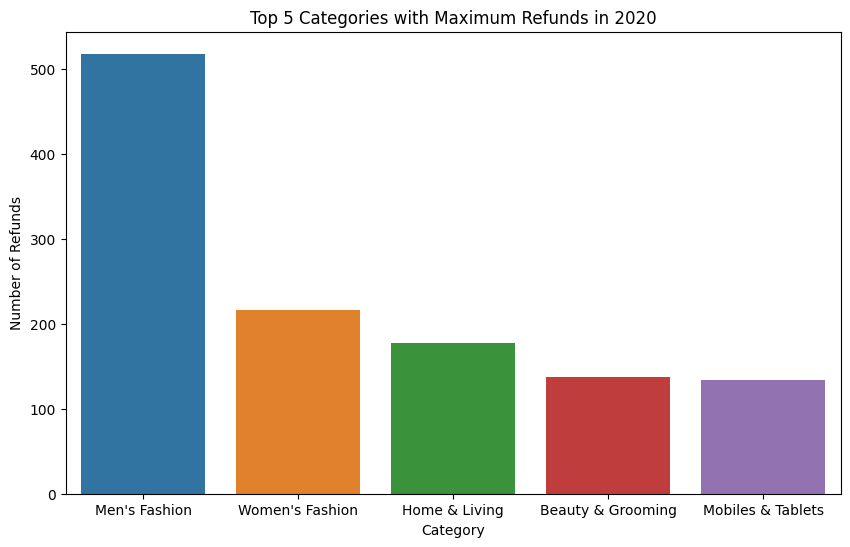

In [0]:
refunds_2020_pd = refunds_2020.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='num_refunds', data=refunds_2020_pd)
plt.title('Top 5 Categories with Maximum Refunds in 2020')
plt.xlabel('Category')
plt.ylabel('Number of Refunds')
plt.show()


#### Customer Loyalty (Repeat Purchases) by Category

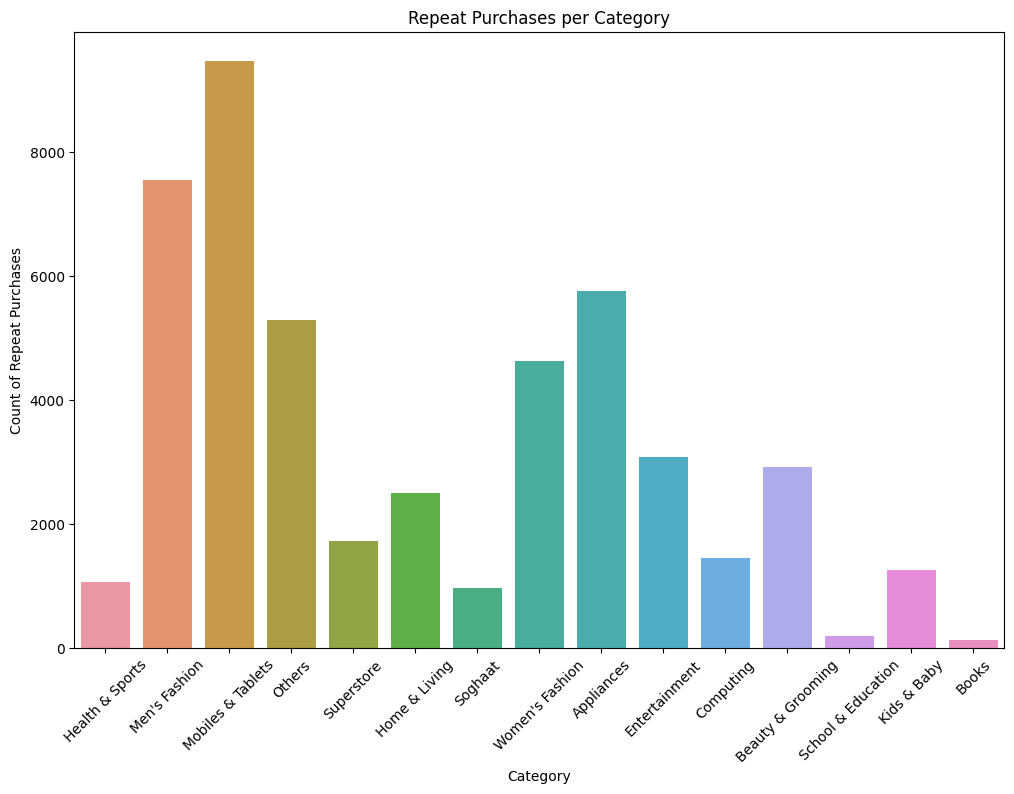

In [0]:
repeat_purchases_detail_pd = repeat_purchases_detail.toPandas()

plt.figure(figsize=(12, 8))
sns.countplot(x='category', data=repeat_purchases_detail_pd)
plt.title('Repeat Purchases per Category')
plt.xlabel('Category')
plt.ylabel('Count of Repeat Purchases')
plt.xticks(rotation=45)
plt.show()


#### Total Spend by Age Segments by Categories

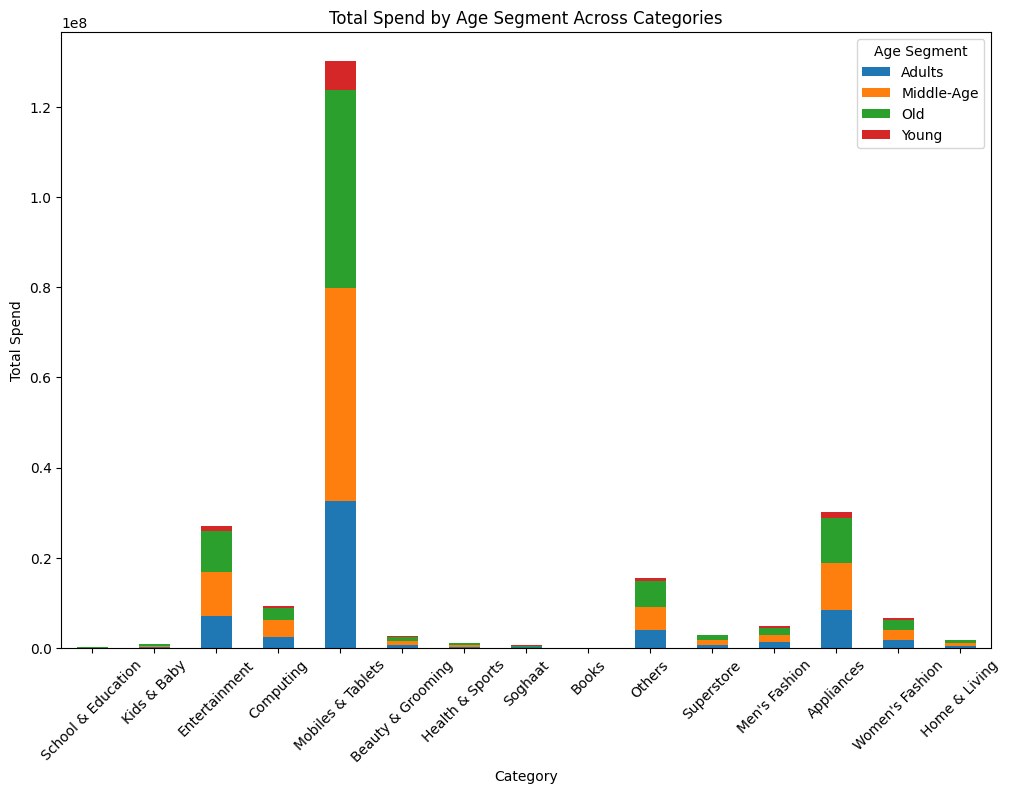

In [0]:
spend_by_age_segment_pd = spend_by_age_segment.toPandas()

# Assuming the columns are 'category', 'Young', 'Adults', 'Middle-Age', 'Old'
spend_by_age_segment_pd.set_index('category', inplace=True)
spend_by_age_segment_pd.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Total Spend by Age Segment Across Categories')
plt.xlabel('Category')
plt.ylabel('Total Spend')
plt.legend(title='Age Segment')
plt.xticks(rotation=45)
plt.show()


#### Spend by Gender Across Different Categories

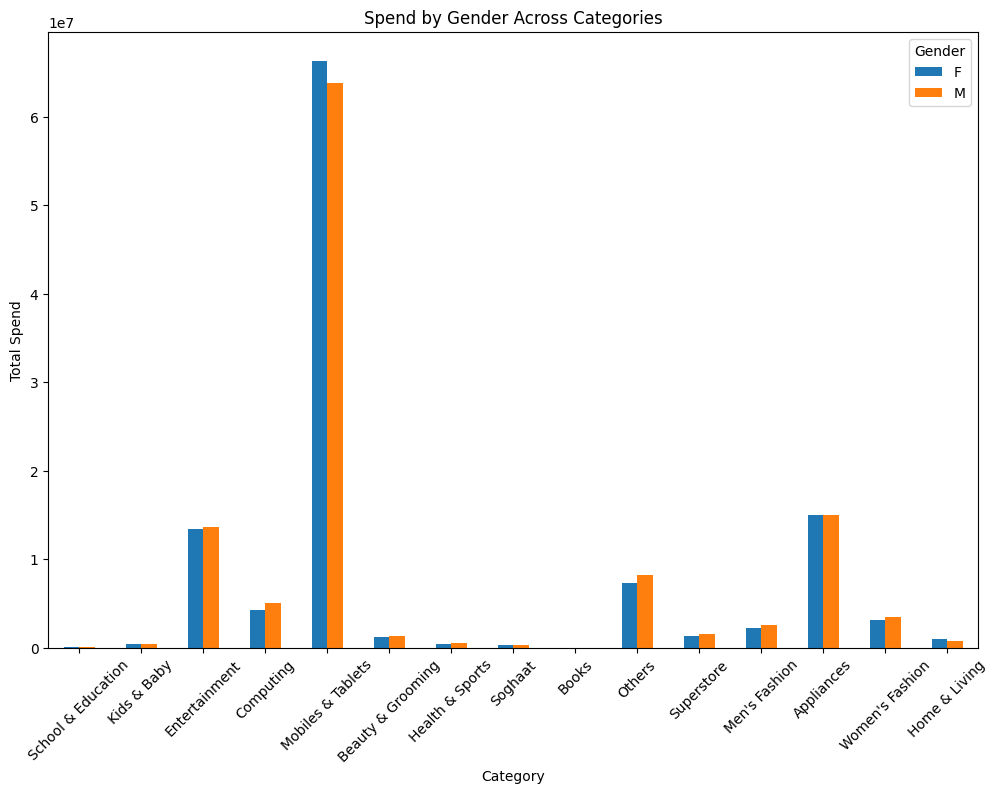

In [0]:
spend_by_gender_pd = spend_by_gender.toPandas()

# Plotting
spend_by_gender_pd.set_index('category', inplace=True)
spend_by_gender_pd.plot(kind='bar', figsize=(12, 8))

plt.title('Spend by Gender Across Categories')
plt.xlabel('Category')
plt.ylabel('Total Spend')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()


#### Top 5 Customers for Each Month

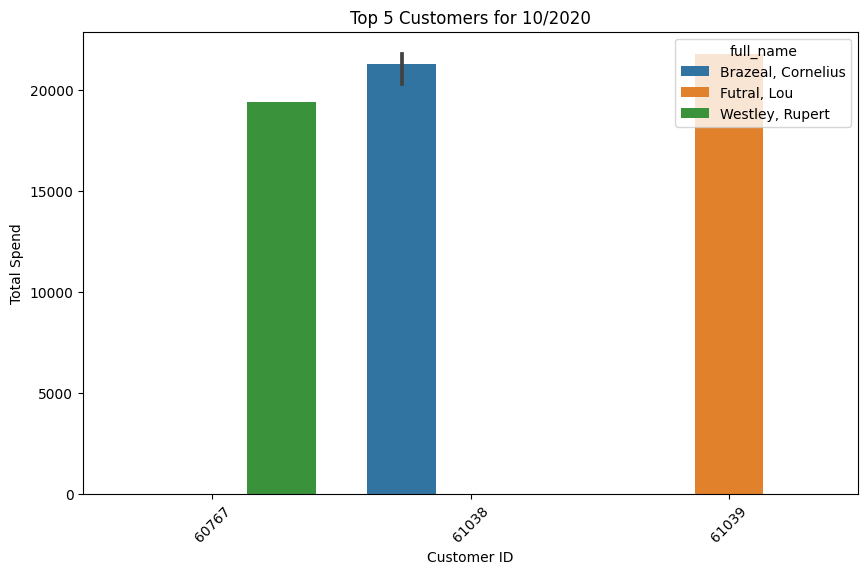

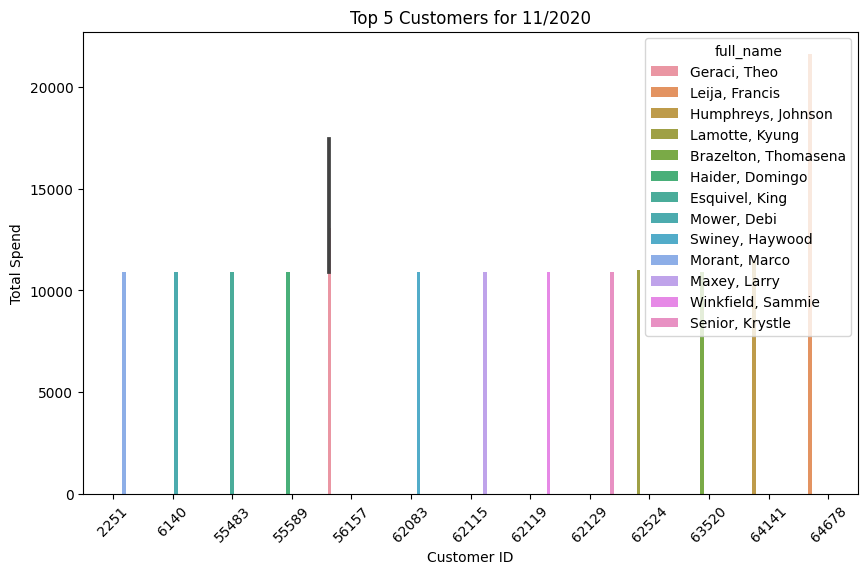

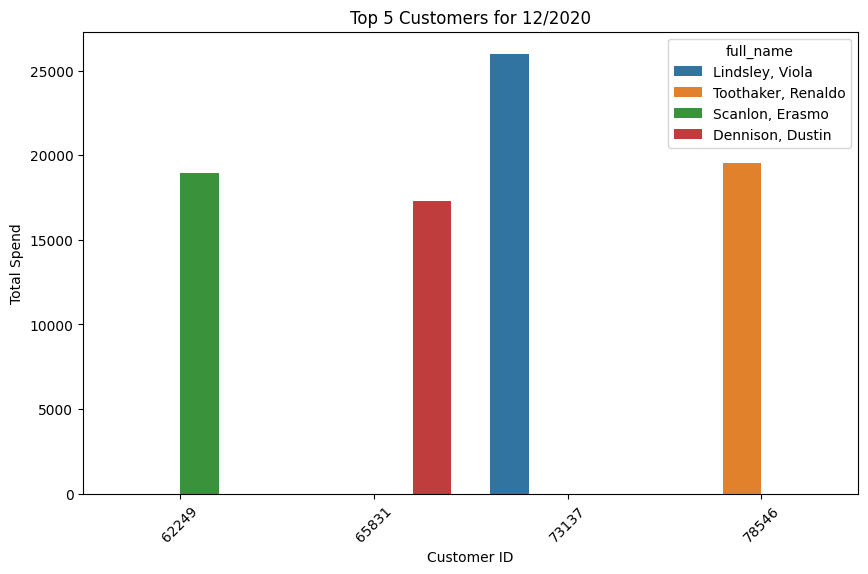

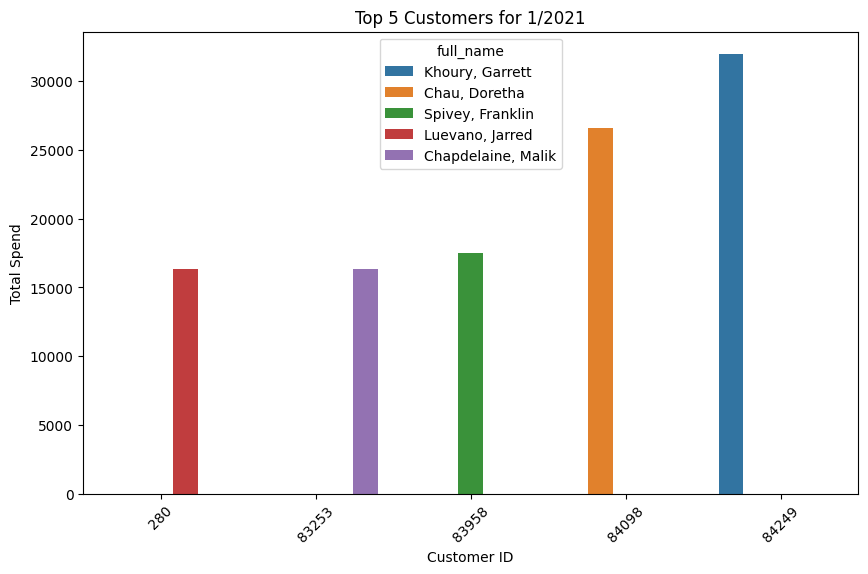

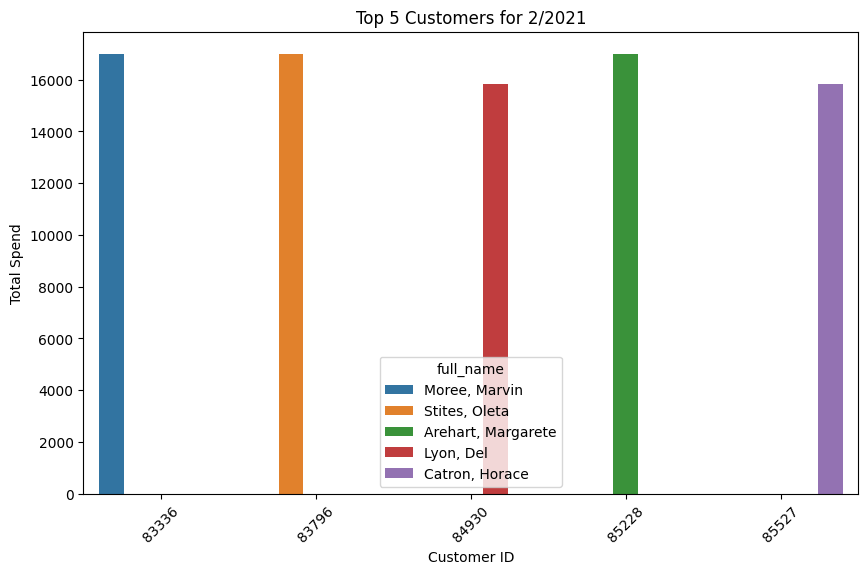

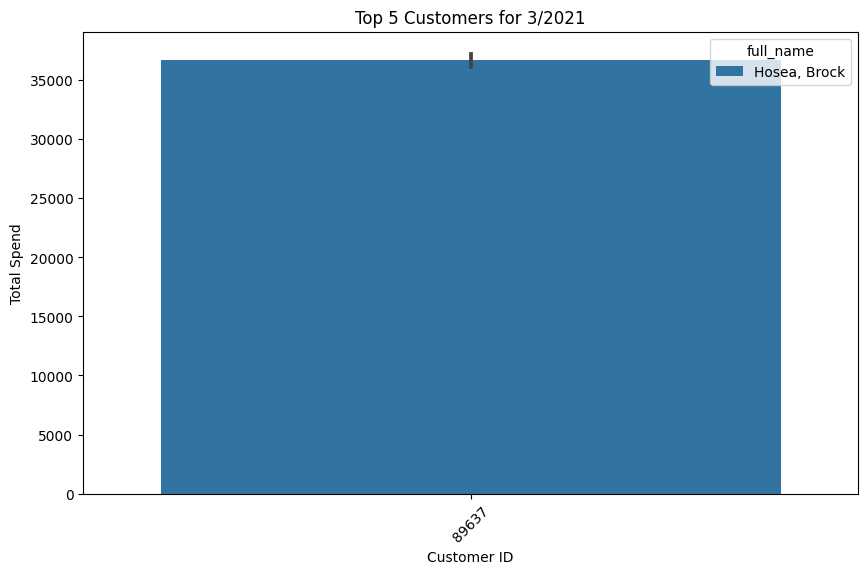

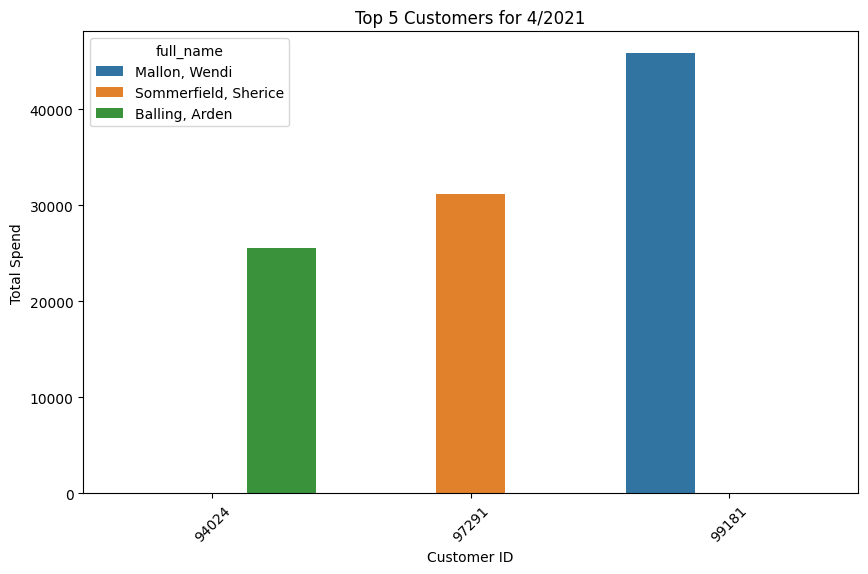

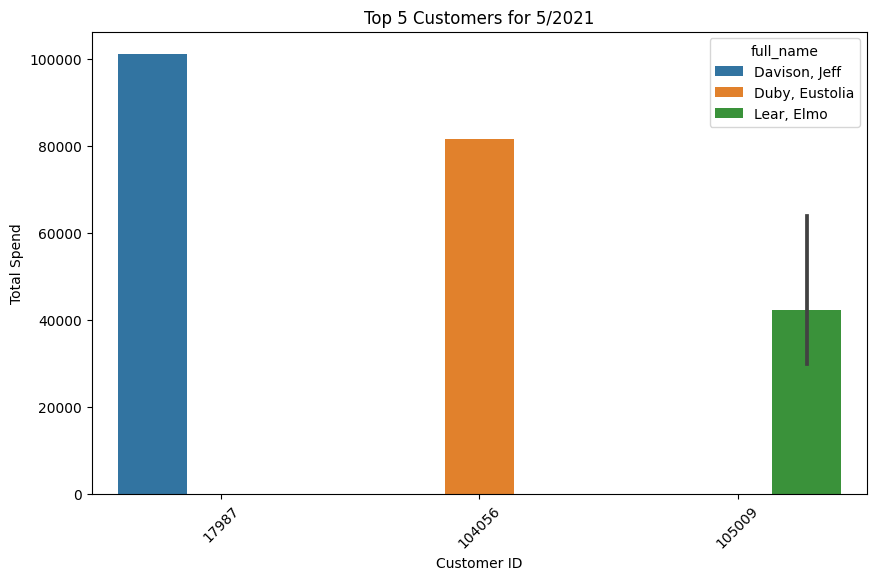

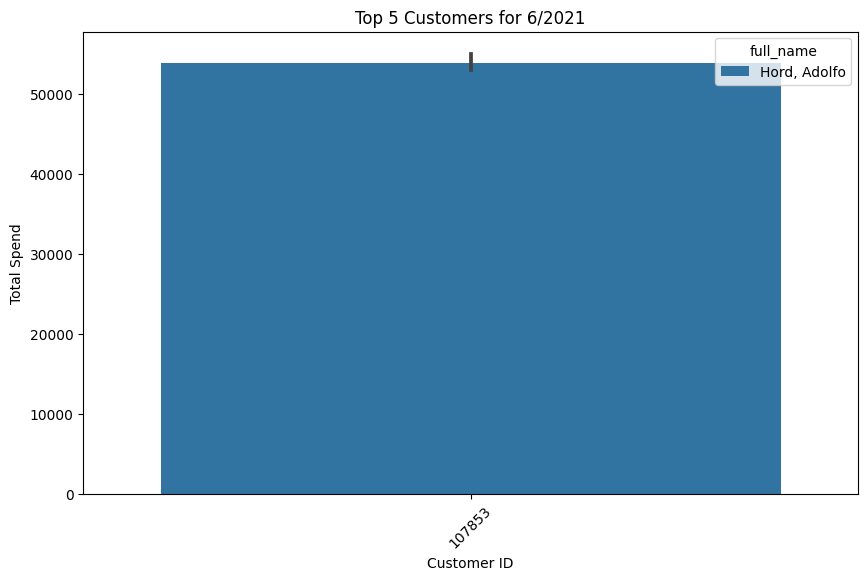

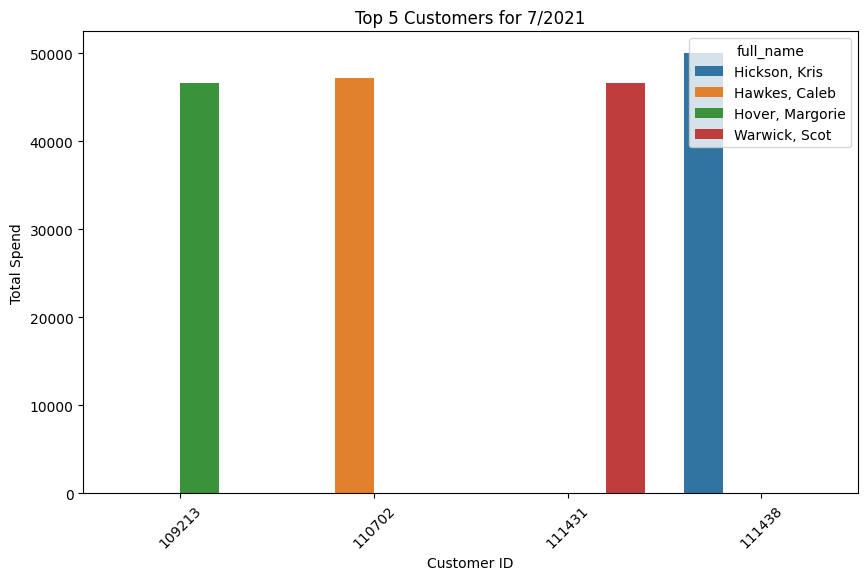

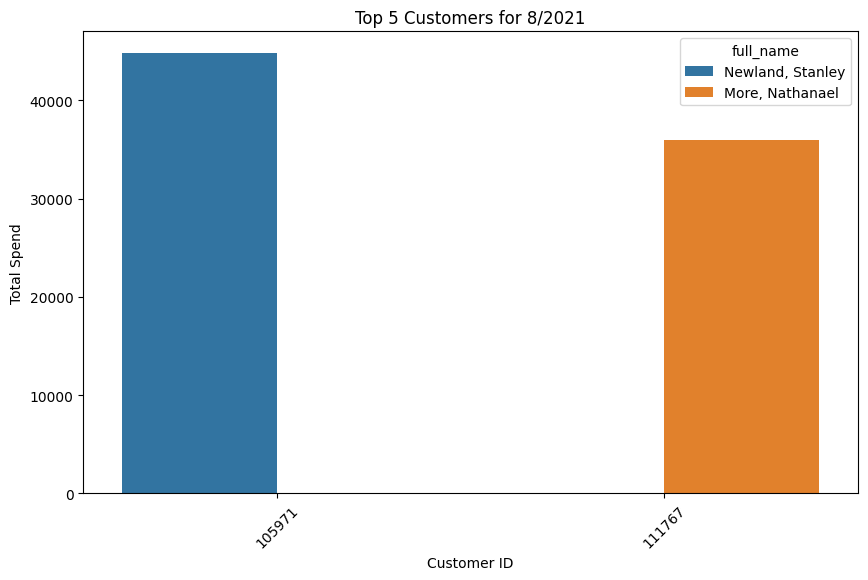

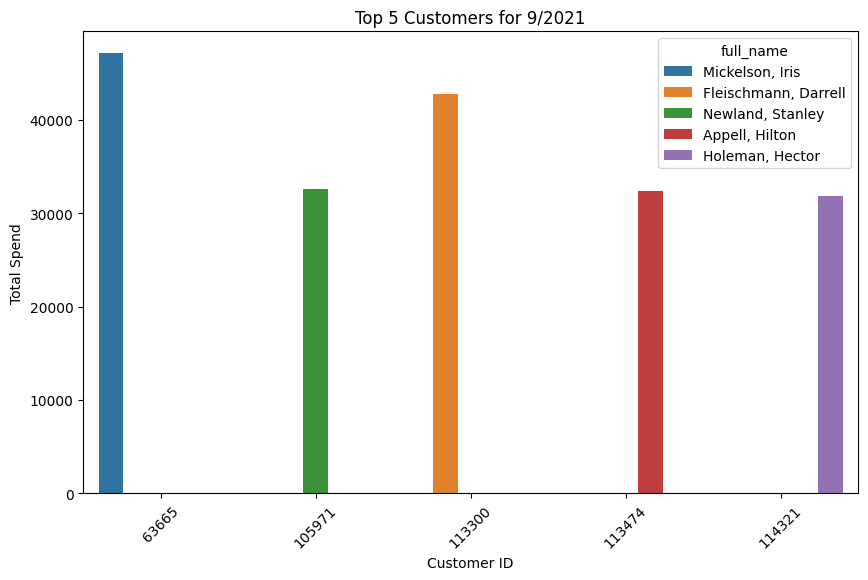

In [0]:
top_customers_pd = top_customers.toPandas()

for (year, month), group in top_customers_pd.groupby(['year', 'month']):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cust_id', y='total', hue='full_name', data=group)
    plt.title(f'Top 5 Customers for {month}/{year}')
    plt.xlabel('Customer ID')
    plt.ylabel('Total Spend')
    plt.xticks(rotation=45)
    plt.show()

#### RFM (Recency, Frequency, Monetary) Values for Each Customer

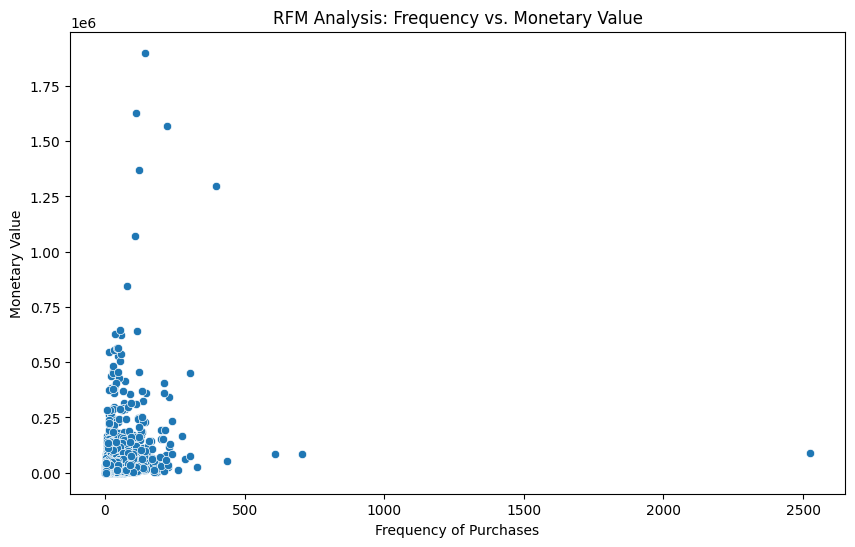

In [0]:
rfm_pd = rfm.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', data=rfm_pd)
plt.title('RFM Analysis: Frequency vs. Monetary Value')
plt.xlabel('Frequency of Purchases')
plt.ylabel('Monetary Value')
plt.show()


#### Top 10 Customers by Frequency and Monetary Value

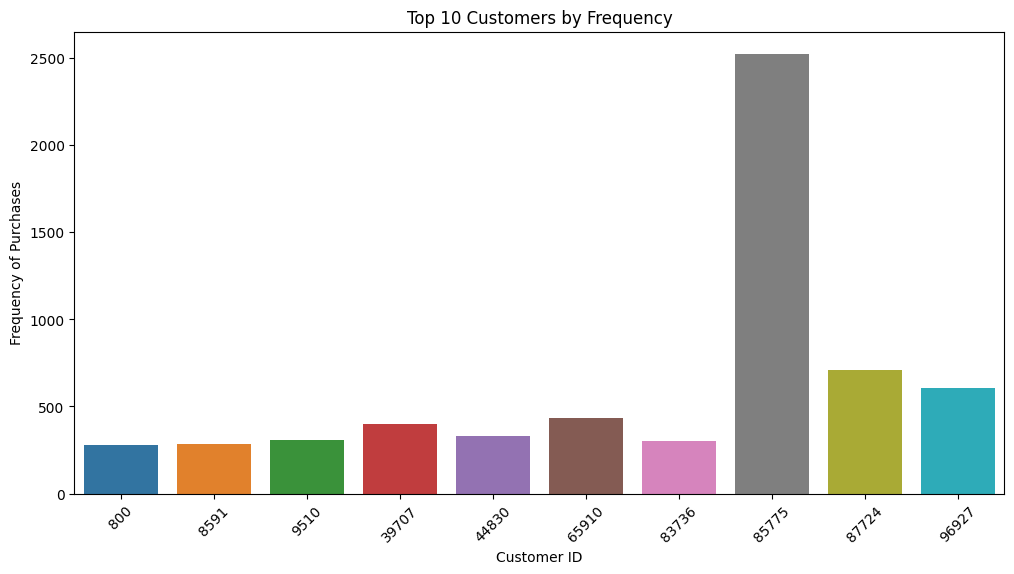

In [0]:
top_10_customers_pd = top_10_customers.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='cust_id', y='frequency', data=top_10_customers_pd)
plt.title('Top 10 Customers by Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Frequency of Purchases')
plt.xticks(rotation=45)
plt.show()


#### Average Order Value by Category

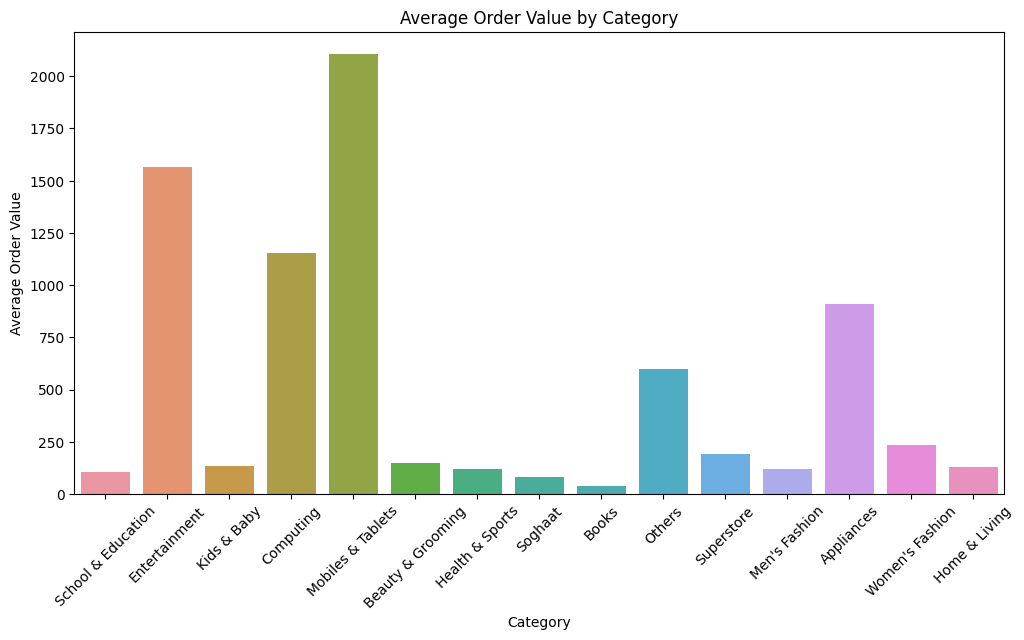

In [0]:
average_order_value_pd = average_order_value.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='avg_order_value', data=average_order_value_pd)
plt.title('Average Order Value by Category')
plt.xlabel('Category')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.show()


#### Customer Loyalty (Repeat Purchases)

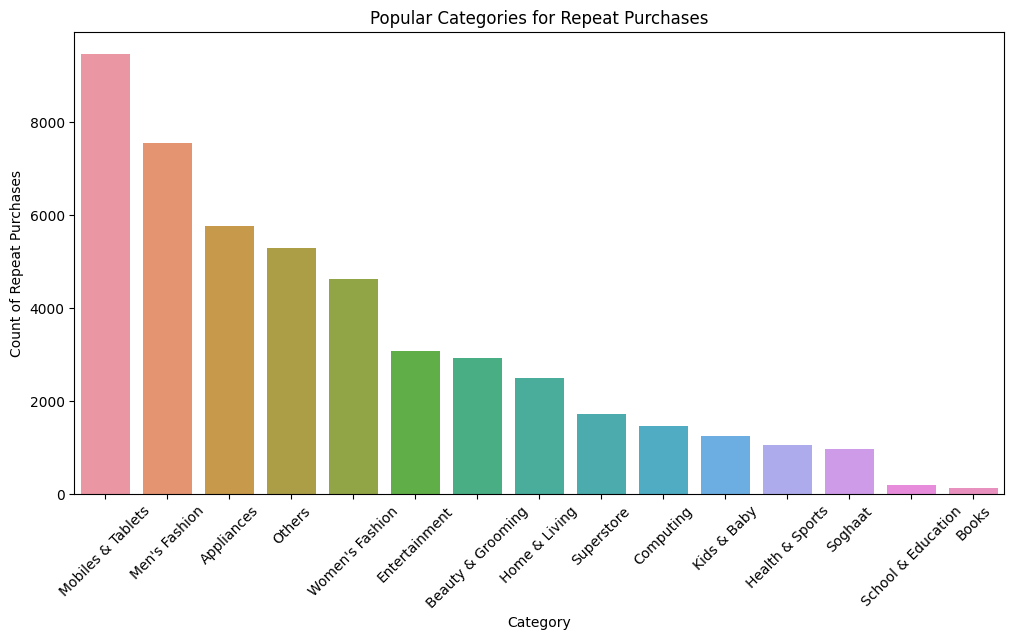

In [0]:
popular_repeat_categories_pd = popular_repeat_categories.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='count', data=popular_repeat_categories_pd)
plt.title('Popular Categories for Repeat Purchases')
plt.xlabel('Category')
plt.ylabel('Count of Repeat Purchases')
plt.xticks(rotation=45)
plt.show()


#### Most Popular Payment Method

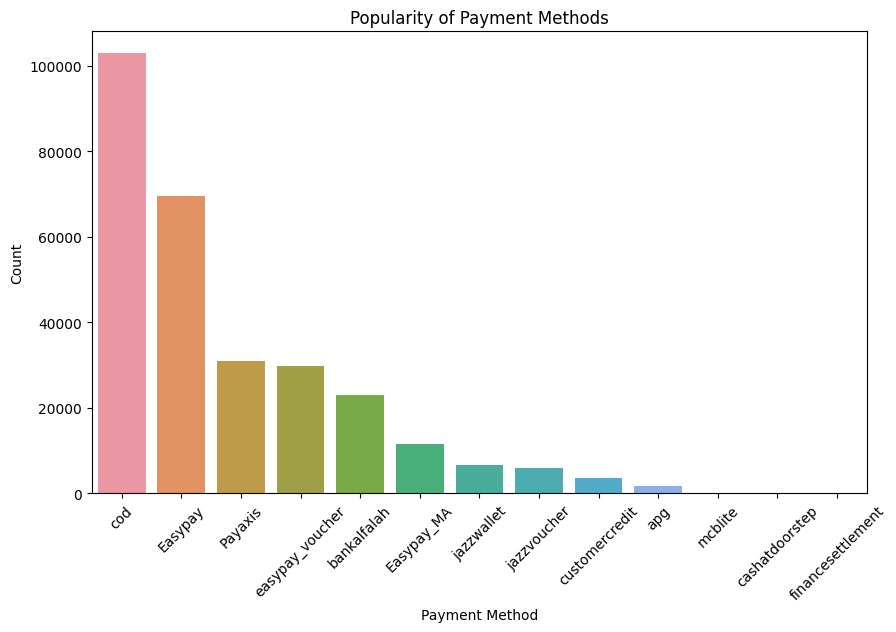

In [0]:
popular_payment_pd = popular_payment.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='payment_method', y='count', data=popular_payment_pd)
plt.title('Popularity of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
